# Earthquake as a triggering factor of an infinite slope mechanism

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/02_trigg_factors/infinite_slope_earthquake.ipynb).


This notebook runs the model ``pyNermarkDisp`` developed by {cite:t}`Montoya-Araque_etal_2024_OpensourceApplicationSoftware` based on the classical sliding rigid block method by {cite:t}`Newmark_1965_EffectsEarthquakesDams`.

## Required modules and global setup for plots

In [1]:
import os
import sys
import subprocess

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
    subprocess.run('pip install pynewmarkdisp', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pynewmarkdisp.newmark import direct_newmark, plot_newmark_integration
from pynewmarkdisp.infslope import factor_of_safety, get_ky

%matplotlib widget

# plt.style.use("default")
mpl.rcParams.update(
    {
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

# Create a folder where the records will be saved
workdir = os.getcwd()
records_dir = os.path.join(workdir, "records")
os.makedirs(f"{records_dir}", exist_ok=True)

## Functions

In [54]:
def load_file(testing_data):
    if testing_data:
        url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/pynewmarkdisp/"
        # record = np.loadtxt(f"{url}earthquake_data_friuli.csv", delimiter=";", skiprows=1)
        # record[:, 1] = - 2.0 * 9.81 * record[:, 1]  # Convert to SI units
        record = np.loadtxt(f"{url}earthquake_data_armenia1999.csv", delimiter=",")
    elif testing_data is False and 'google.colab' in str(get_ipython()):
        file = files.upload()
        # Move the file to the records folder
        os.rename(list(file.keys())[0], os.path.join(records_dir, list(file.keys())[0]))
        record = np.loadtxt(os.path.join(records_dir, list(file.keys())[0]))
    else:  # GUI for file selection from local machine if not in CoLab
        tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
        file = askopenfilename()
        # Move the file to the records folder
        os.rename(file, os.path.join(records_dir, os.path.basename(file)))
        record = np.loadtxt(os.path.join(records_dir, os.path.basename(file)))
    time, accel = record.T
    return time, accel
    
def get_arias_intensity(time, accel, g):
    return np.trapz(y=accel**2, x=time) * np.pi / (2 * g)

def get_pgv(time, accel, g):
    accel = 9.81 * accel / g  # Earthquake acceleration to SI units
    vel = np.cumsum(accel) * (time[1] - time[0])
    return np.max(np.abs(vel))

def get_pga(accel, g):
    accel = 9.81 * accel / g  # Earthquake acceleration to SI units
    return np.max(np.abs(accel))

## Running a case

In [55]:
testing_data = True  # Set to False to use the GUI to load the data from an external file

### Inputs (conditioning factors)

In [75]:
# Geometry
β = 35  # [°] - Slope angle - Plane inclination
d = 1.5  # [m] - Depth of the slip surface - Block height
d_w = 1.5  # [m] - Depth of the water table

# Material parameters
φ = 30  # [°] - Friction angle
c = 5  # [kPa] - Cohesion
γ = 19  # [kN/m³] - Unit weight

### Inputs (triggering factor - Earthquake record)

In [76]:
time, accel = load_file(testing_data)
time, accel

(array([0.0000e+00, 5.0000e-03, 1.0000e-02, ..., 3.4985e+01, 3.4990e+01,
        3.4995e+01]),
 array([0.00246051, 0.00246493, 0.00246935, ..., 0.02309875, 0.05239547,
        0.08169219]))

In [77]:
# Value of gravity acceleration in the same units as in the earthquake record
# g = 1.0   # → It means that acceleration units in the input file are given in [g]
g = 9.81  #  → It means that acceleration units in the input file are given in [m/s²]
# g = 981  #  → It means that acceleration units in the input file are given in [cm/s²]

### Static factor of safety, $\mathrm{FS}_\mathrm{static}$

In [78]:
fs = factor_of_safety(d, d_w, β, φ, c, γ, ks=0)
print(f"Static factor of safety: {fs:.2f}")

Static factor of safety: 1.20


### Critical seismic coefficient $k_\mathrm{y}$

In [79]:
ky = get_ky(d, d_w, β, φ, c, γ)
print(f"Critical seismic coefficient, ky: {ky:.2f}")

Critical seismic coefficient, ky: 0.10


### Pseudo-static factor of safety,  $\mathrm{FS}_\mathrm{pseudostatic}$, when $k_\mathrm{s}$ is 40% of $k_\mathrm{y}$

In [80]:
ks = 0.4 * ky
fs_ks = factor_of_safety(d, d_w, β, φ, c, γ, ks)
print(f"Pseudostatic factor of safety: {fs_ks:.2f}")

decrease_fs = (fs - fs_ks) / fs * 100
print(f"Decrease in factor of safety: {decrease_fs:.2f} %")

Pseudostatic factor of safety: 1.11
Decrease in factor of safety: 7.18 %


### Calculating and plotting $u_\mathrm{p}$

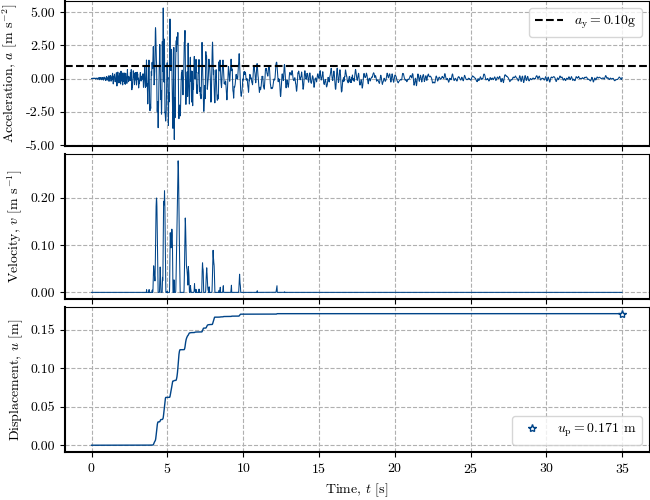

In [81]:
permanent_disp = direct_newmark(time, accel, ky, g)
fig = plot_newmark_integration(permanent_disp)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()